In [1]:
!pip install gdown

# **Download Our Data from Drive**

In [ ]:
!gdown "https://drive.google.com/uc?id=1MpPHfA9N1keV0CJsXwm_sQF0mle822v9"

Downloading...
From (original): https://drive.google.com/uc?id=1MpPHfA9N1keV0CJsXwm_sQF0mle822v9
From (redirected): https://drive.google.com/uc?id=1MpPHfA9N1keV0CJsXwm_sQF0mle822v9&confirm=t&uuid=45eed8b2-a8fe-4753-9446-925500e2b404
To: /content/FINAL.zip
100% 2.60G/2.60G [00:53<00:00, 49.1MB/s]


#**Necessary Imports**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import tensorflow as tf
from keras.losses import MeanSquaredError
import gdown
import zipfile

# **Unzip Data**



In [ ]:
zip_file_path = "/content/FINAL.zip"

# Define the destination directory
dest_dir = "/content/"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

In [ ]:
datadir = '/content/FINAL'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'annotations.csv'), names = columns, skiprows=1)
# pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_image_000001.png,left_image_000001.png,right_image_000001.png,0.0,0.000000,0,0.3845
1,center_image_000002.png,left_image_000002.png,right_image_000002.png,0.0,0.000000,0,0.6994
2,center_image_000003.png,left_image_000003.png,right_image_000003.png,0.0,0.000000,0,0.2751
3,center_image_000004.png,left_image_000004.png,right_image_000004.png,0.0,0.000000,0,0.2351
4,center_image_000005.png,left_image_000005.png,right_image_000005.png,0.0,0.095925,0,0.2594


In [4]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

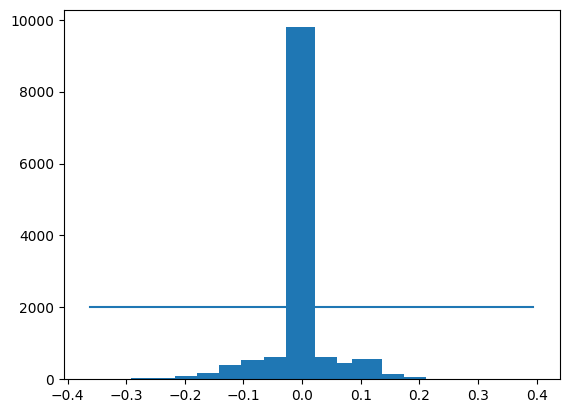

In [ ]:
num_bins = 20
samples_per_bin = 2000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5 # center the data around 0
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

# **Filter Data**

This data is based on driving on a track, most of the time the driving is straight. So, we filter out some data inorder to make the model unbias for driving in the center

removed: 7789
remaining: 5823


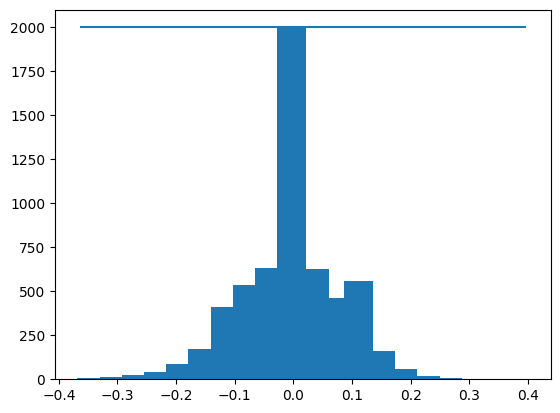

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

# **Prepare Images and Steering angles**

Here we load the 3 image from: front center, front left and front right.


In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []

  for i in range(len(data)):

    indexed_data = data.iloc[i]
    if indexed_data[3] <= 0.05 and indexed_data[3] >= -0.05 and indexed_data[4] < 0.1:
      continue

    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    # append left image
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])-0.15)

    # append right image
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])+0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

# **Loading Data And Split them into Train/Val/Test**

In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))


<ipython-input-16-2edfc559289b>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if indexed_data[3] <= 0.05 and indexed_data[3] >= -0.05 and indexed_data[4] < 0.1:
<ipython-input-16-2edfc559289b>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-16-2edfc559289b>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3

Training Samples: 12859
Valid Samples: 3215


#**Visualization Of Training and Validiation Data**


Text(0.5, 1.0, 'Validation set')

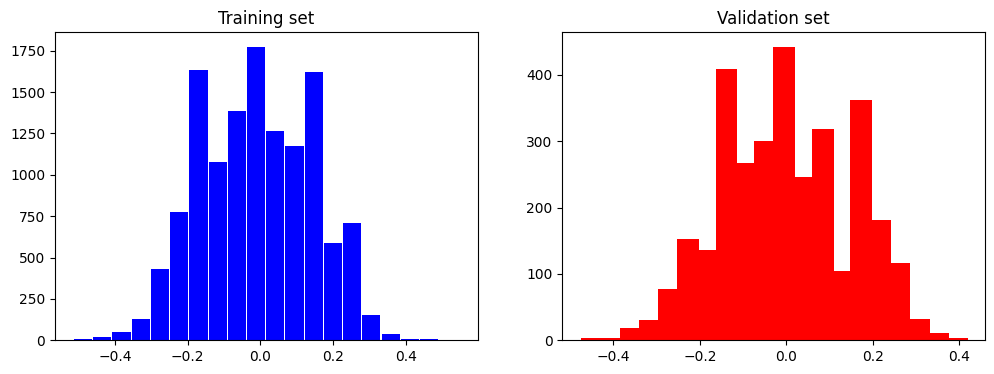

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

#**Data Augmentation**
Based on The Paper, a number of augmentation must be done to the data. like: zooming, panning, reduce brightness and flipling
Those should be chosen randomly from a normal distbinution.

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image


def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image



def reduce_brightness(image):
    brightness = iaa.Multiply(0.4)
    image = brightness.augment_image(image)
    return image



def flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle



def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = reduce_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = flip(image, steering_angle)

    return image, steering_angle

#**Pre Process Image**
before the model uses each batch for training, each image in the batch must undergo a preprocessing phase:
- The upper half we be cropped.
- Changing rom RGB to YUV.
- resize the image like in the paper.

In [12]:
def img_preprocess(img):
    img = img[65:200,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    # img = img/255
    return img

#**Example of preprocessed  image**

Text(0.5, 1.0, 'Preprocessed Image')

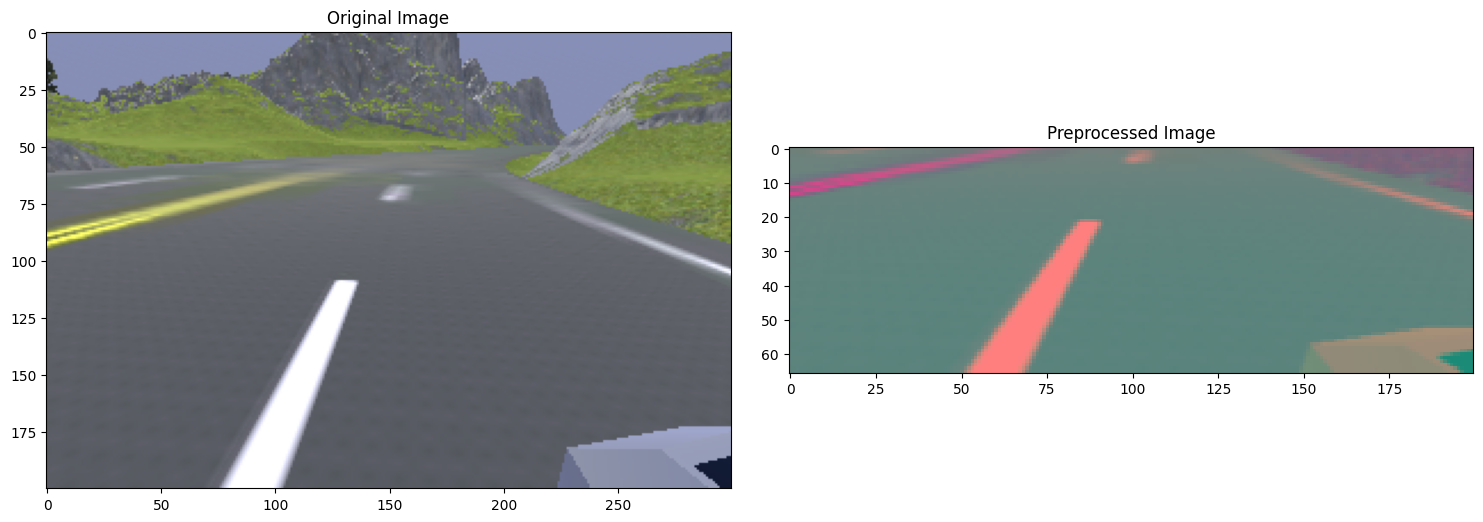

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

#**Batch Generator**
At each iteration a random image will be chosen in the batch based on a noraml distribution. this image will undergo augumenation process.

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

#**Network Architecture**

In [ ]:
def nvidia_model():
    network = Sequential()

    network.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2), input_shape=(200, 66, 3)))
    network.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    network.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    network.add(Conv2D(64, (3, 3), activation='elu'))
    network.add(Conv2D(64, (3, 3), activation='elu'))

    # Add dropout
    network.add(Dropout(0.5))
    # Flatten and fully connected layers
    network.add(Flatten())
    network.add(Dense(100, activation='elu'))
    network.add(Dense(50, activation='elu'))
    network.add(Dense(10, activation='elu'))
    network.add(Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    network.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    return network

network = nvidia_model()
print(network.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 98, 31, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 47, 14, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 5, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 3, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 1, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


#**Train the model**

In [ ]:
history = network.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

#**Plot Results**

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


In [ ]:
network.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Download tacks data and model**




In [2]:
!gdown "https://drive.google.com/uc?id=1GON4xpFuIi62uErl7xTCnG8tjVHk8xf3" # DAVE-2 model
!gdown "https://drive.google.com/uc?id=1zQTNmIPt-pL0ZBxldPHdoQgVqgJaXcvp" # Track 2
!gdown "https://drive.google.com/uc?id=1LQiFguCr9_SyVRKW0cTPmGuPsrg8qNTk" # Track 5



Downloading...
From: https://drive.google.com/uc?id=1GON4xpFuIi62uErl7xTCnG8tjVHk8xf3
To: /content/FINAL.h5
100% 3.10M/3.10M [00:00<00:00, 26.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zQTNmIPt-pL0ZBxldPHdoQgVqgJaXcvp
To: /content/Track2 2.zip
100% 18.7M/18.7M [00:01<00:00, 17.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LQiFguCr9_SyVRKW0cTPmGuPsrg8qNTk
To: /content/Track3.zip
100% 12.6M/12.6M [00:00<00:00, 39.4MB/s]


#**Our Results**
Here we show the activation of the first two convolutional layers

In [ ]:

model = load_model('FINAL.h5')
input_shape = (200, 66, 3)
dummy_input = tf.keras.Input(shape=input_shape)
model(dummy_input)

example_1 = mpimg.imread("/content/center_image_000273.png")
example_1 = img_preprocess(example_1)
example_1 = cv2.resize(example_1, (66,200,))
example_1 = np.expand_dims(example_1, axis=0)

layer_outputs = [layer.output for layer in model.layers[:2]]

activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)


example_1 = model.layers[0](example_1)
activation_layer_1 = example_1.numpy()
print("Activation Shape for Layer 1:", activation_layer_1.shape)

example_1 = model.layers[1](example_1)
activation_layer_2 = example_1.numpy()
print("Activation Shape for Layer 2:", activation_layer_2.shape)

Activation Shape for Layer 1: (1, 98, 31, 24)
Activation Shape for Layer 2: (1, 47, 14, 36)


In [ ]:
def plot_feature_maps(activation, title):
    n_features = activation.shape[-1]
    original_size = activation.shape[1:3]
    square_size = max(original_size)


    plt.figure(figsize=(15, 15))
    plt.suptitle(title, fontsize=16)

    for i in range(min(n_features, 16)):

        feature_map = activation[0, :, :, i]
        resized_feature_map = cv2.resize(feature_map, (square_size, square_size))

        ax = plt.subplot(4, 4, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(resized_feature_map, cmap='gray')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

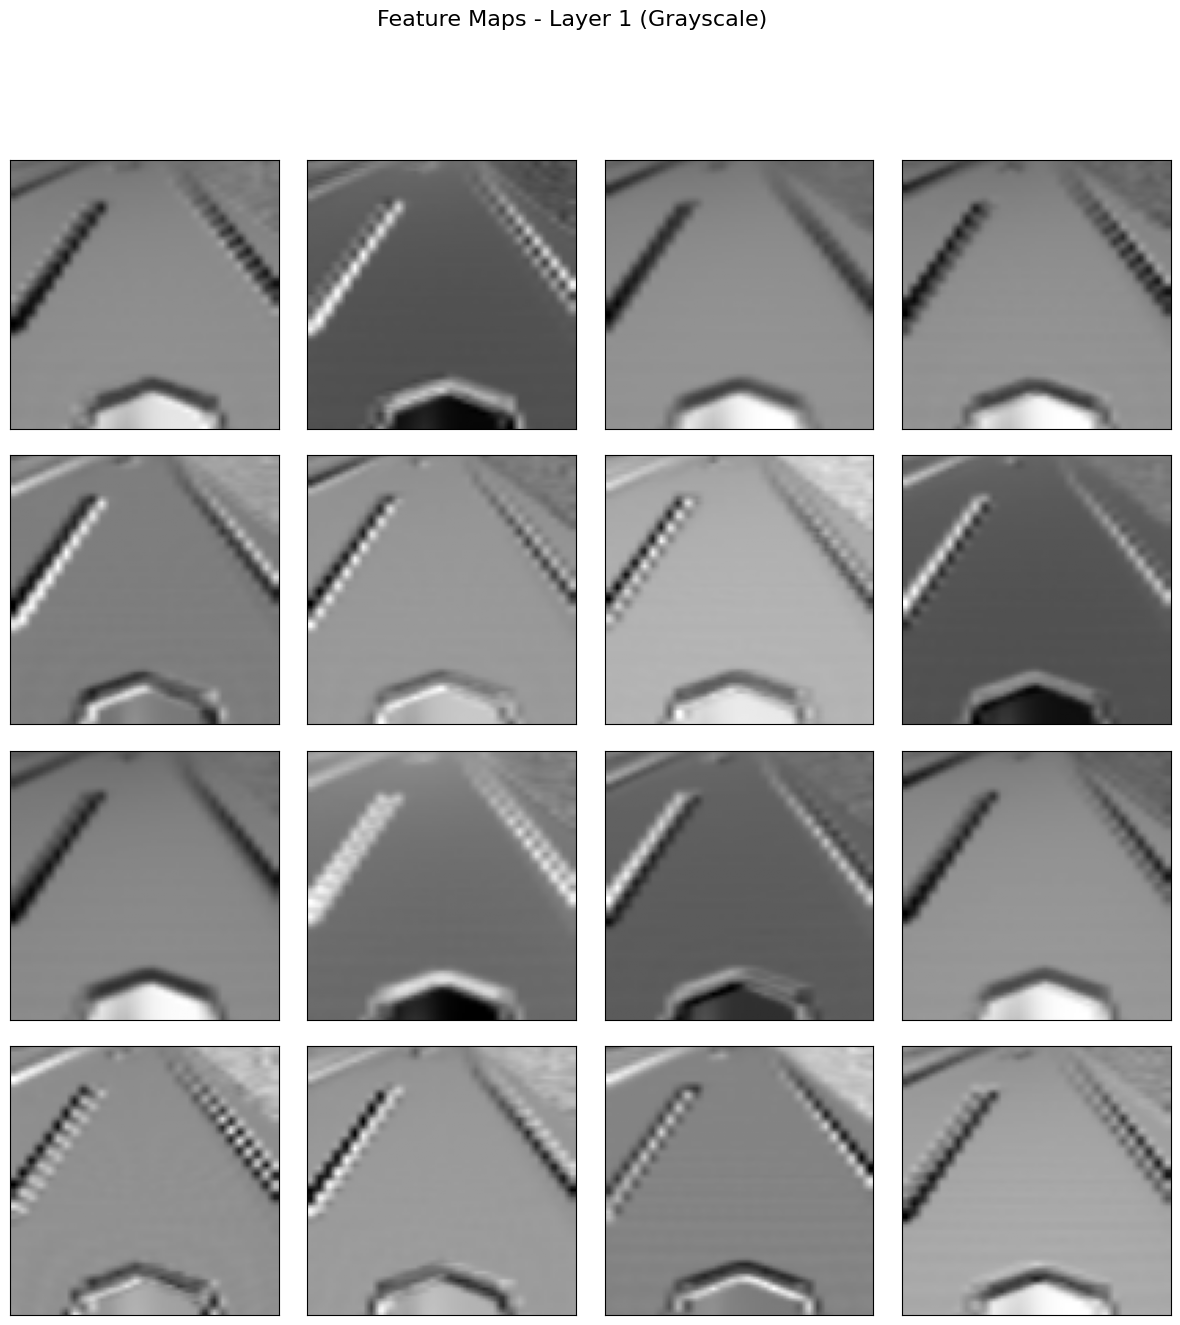

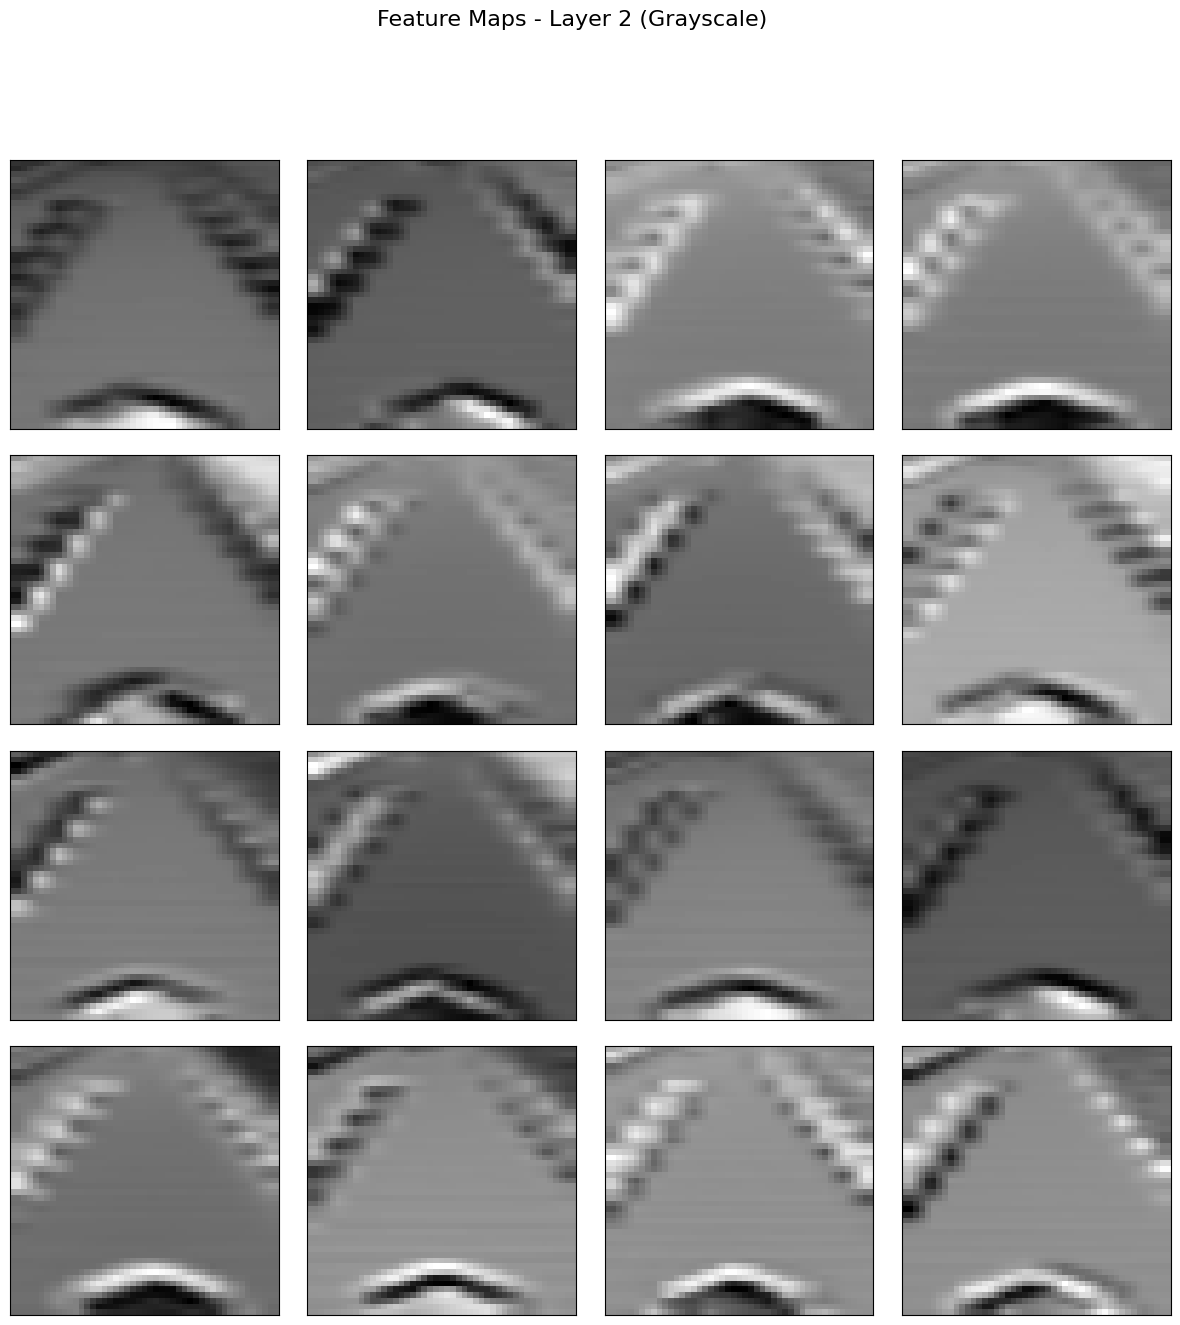

In [ ]:
plot_feature_maps(activation_layer_1, "Feature Maps - Layer 1 (Grayscale)")

plot_feature_maps(activation_layer_2, "Feature Maps - Layer 2 (Grayscale)")


#**Unzip Data**

In [19]:

track_names = ['/content/Track2 2.zip', '/content/Track3.zip']

for track_name in track_names:

  # Define the destination directory
  dest_dir = "/content/"

  # Create the destination directory if it doesn't exist
  os.makedirs(dest_dir, exist_ok=True)

  # Unzip the file
  with zipfile.ZipFile(track_name, 'r') as zip_ref:
      zip_ref.extractall(dest_dir)

#**Load data**

In [5]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []

  for i in range(len(data)):

    indexed_data = data.iloc[i]
    if indexed_data[3] <= 0.05 and indexed_data[3] >= -0.05 and indexed_data[4] < 0.1:
      continue

    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [20]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
all_image_paths = []
all_steerings = []
track_names = ['/content/Track2.zip', '/content/Track3.zip']

for track_name in track_names:

  datadir = track_name[:-4]
  data = pd.read_csv(os.path.join(datadir, 'annotations.csv'), names = columns, skiprows=1)
  data['center'] = data['center'].apply(path_leaf)
  image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  all_image_paths.append(image_paths)
  all_steerings.append(steerings)


<ipython-input-5-9ef5b3517935>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if indexed_data[3] <= 0.05 and indexed_data[3] >= -0.05 and indexed_data[4] < 0.1:
<ipython-input-5-9ef5b3517935>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-5-9ef5b3517935>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))

#**Test Our model on tracks**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

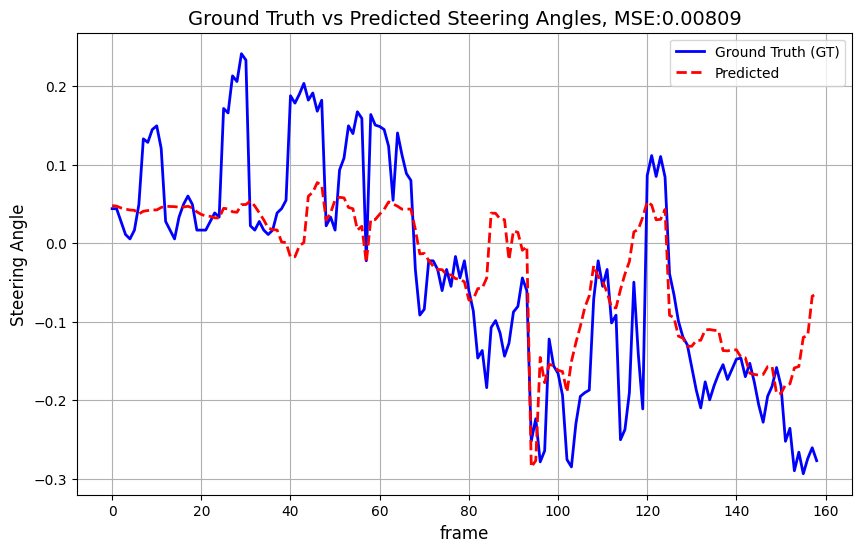

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

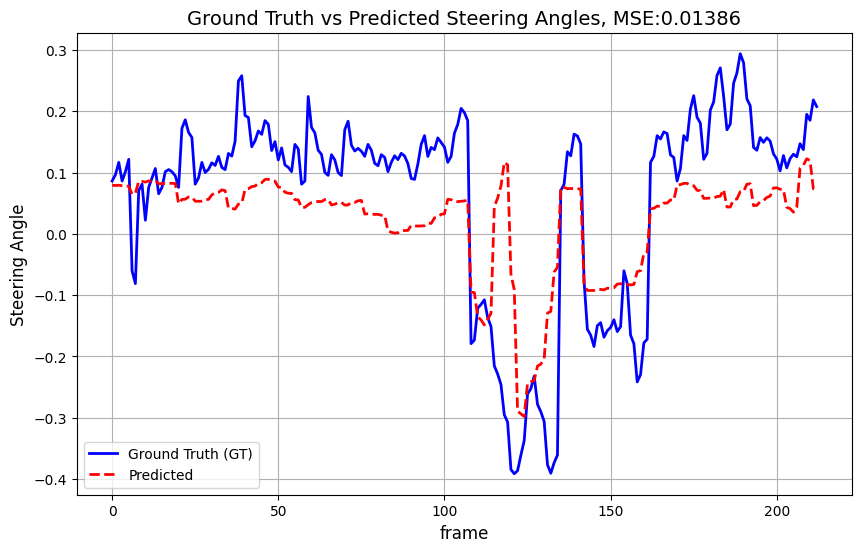

In [21]:
from sklearn.metrics import mean_squared_error

model = load_model('FINAL.h5')

for i in range(len(all_image_paths)):
  image_paths = all_image_paths[i]
  steerings = all_steerings[i]
  predicted_steerings = []
  gt_steerings = []
  for j in range(len(image_paths)):

    img = mpimg.imread(image_paths[j])
    gt_steering = steerings[j]
    if gt_steering == 0:
      continue
    img = img_preprocess(img)
    img = cv2.resize(img, (66,200,))
    img = np.expand_dims(img, axis=0)
    predicted_steering = model.predict(img)
    predicted_steerings.append(predicted_steering)
    gt_steerings.append(gt_steering)

  predicted_steerings = np.array(predicted_steerings).flatten()
  gt_steerings = np.array(gt_steerings).flatten()

  mse = mean_squared_error(gt_steerings, predicted_steerings)
  print(f"MSE for track {i+1}: {mse}")

  # Plot ground truth and predictions
  plt.figure(figsize=(10, 6))
  plt.plot(gt_steerings, label='Ground Truth (GT)', color='blue', linewidth=2)
  plt.plot(predicted_steerings, label='Predicted', color='red', linestyle='--', linewidth=2)
  plt.xlabel('frame', fontsize=12)
  plt.ylabel('Steering Angle', fontsize=12)
  plt.title(f'Ground Truth vs Predicted Steering Angles, MSE:{round(mse,5)}', fontsize=14)
  plt.legend()
  plt.grid(True)
  plt.show()



